## L&T EduTech Hackathon: Problem Statement 1
Deep Learning framework for Crack Detection

In [2]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow_addons.metrics import F1Score

import matplotlib.pyplot as plt

In [ ]:
# Config Variables
DIR = "./Surface Crack" # Replace with Path to Data Folder

## Load Data

In [4]:
def load_images(directory, subset, batch_size=32, image_size=(224, 224), shuffle=False):
    directory = os.path.join(directory, subset)
    return image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        class_names=['Negative','Positive'],
        color_mode="rgb",
        batch_size=batch_size,
        image_size=image_size,
        shuffle=shuffle,
    ).cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_ds = load_images(DIR, 'train', shuffle=True)
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
valid_ds = load_images(DIR, 'valid', shuffle=True)
print("Number of validation samples: %d" % tf.data.experimental.cardinality(valid_ds))
test_ds = load_images(DIR, 'test', shuffle=True)
print("Number of testing samples: %d" % tf.data.experimental.cardinality(test_ds))

Found 600 files belonging to 2 classes.
Number of training samples: 19
Found 200 files belonging to 2 classes.
Number of validation samples: 7
Found 200 files belonging to 2 classes.
Number of testing samples: 7


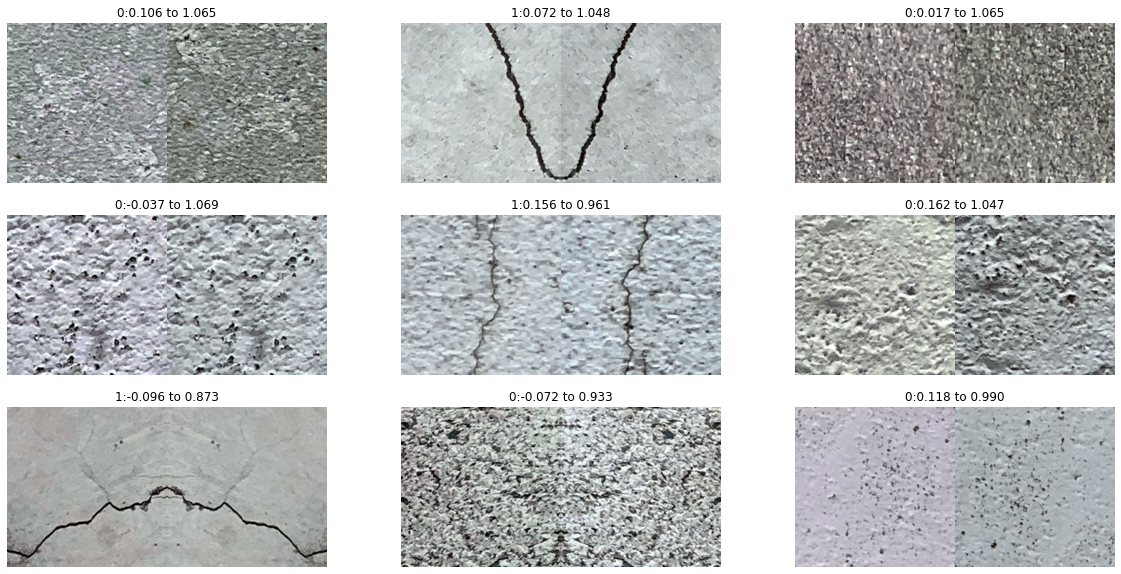

In [6]:
plt.figure(figsize=(20, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    x = image[-1]/255
    x = tf.image.random_brightness(x, 0.1)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    x = tf.image.random_hue(x, 0.3)
    x = tf.image.random_saturation(x, 0.7, 1.3)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = tf.clip_by_value(x, clip_value_min=0, clip_value_max=1)
    plt.imshow(np.concatenate([x,image[-1]/255],axis=1))
    plt.title(f"{int(label[-1])}:{np.min(x):.3f} to {np.max(x):.3f}")
    plt.axis("off")

## Deep Learning Model

In [7]:
#@title Select model architecture
#@markdown Provided are the models that performed well in initial round

model_name = "MobileNet"  #@param ['NASNetMobile','InceptionV3','MobileNetV2','ResNet101V2','InceptionResNetV2','ResNet50V2','Xception','NASNetLarge','ResNet152V2','MobileNet']

model_dict = {
    'NASNetMobile':{"model":tf.keras.applications.nasnet.NASNetMobile,"preprocess_fn":tf.keras.applications.nasnet.preprocess_input},
    'InceptionV3':{"model":tf.keras.applications.inception_v3.InceptionV3,"preprocess_fn":tf.keras.applications.inception_v3.preprocess_input},
    'MobileNetV2':{"model":tf.keras.applications.mobilenet_v2.MobileNetV2,"preprocess_fn":tf.keras.applications.mobilenet_v2.preprocess_input},
    'ResNet101V2':{"model":tf.keras.applications.resnet_v2.ResNet101V2,"preprocess_fn":tf.keras.applications.resnet_v2.preprocess_input},
    'InceptionResNetV2':{"model":tf.keras.applications.inception_resnet_v2.InceptionResNetV2,"preprocess_fn":tf.keras.applications.inception_resnet_v2.preprocess_input},
    'ResNet50V2':{"model":tf.keras.applications.resnet_v2.ResNet50V2,"preprocess_fn":tf.keras.applications.resnet_v2.preprocess_input},
    'Xception':{"model":tf.keras.applications.xception.Xception,"preprocess_fn":tf.keras.applications.xception.preprocess_input},
    'NASNetLarge':{"model":tf.keras.applications.nasnet.NASNetLarge,"preprocess_fn":tf.keras.applications.nasnet.preprocess_input},
    'ResNet152V2':{"model":tf.keras.applications.resnet_v2.ResNet152V2,"preprocess_fn":tf.keras.applications.resnet_v2.preprocess_input},
    'MobileNet':{"model":tf.keras.applications.mobilenet.MobileNet,"preprocess_fn":tf.keras.applications.mobilenet.preprocess_input}
}

model_props = model_dict[model_name]

In [8]:
INPUT_SHAPE = (224, 224, 3)
base_model = model_props["model"](
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=INPUT_SHAPE,
    include_top=False,
    pooling='avg'
)

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=INPUT_SHAPE)

# Pre-trained Xception weights requires that input be preprocessed
x = model_props["preprocess_fn"](inputs)

# Augmentation
x = tf.image.random_brightness(x, 0.1)
x = tf.image.random_contrast(x, 0.7, 1.3)
x = tf.image.random_hue(x, 0.3)
x = tf.image.random_saturation(x, 0.7, 1.3)
x = tf.image.random_flip_left_right(x)
x = tf.image.random_flip_up_down(x)
# x = tf.image.random_jpeg_quality(x, 50, 99) # Can't apply as floats are expected to be in [0,1) range
if "MobileNet" in model_name:
    x = tf.clip_by_value(x, clip_value_min=-1, clip_value_max=1) # For MobiNet Only

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

model.summary(show_trainable=True)

17225924/17225924 [==============================] - 1s 0us/step
Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         Y          
 )                                                                          
                                                                            
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         Y          
 a)                                                                         
                                                                            
 tf.image.adjust_brightness   (None, 224, 224, 3)      0         Y          
 (TFOpLambda)                                                            

In [9]:
%%time
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), F1Score(1, 'micro', threshold=0.5)],
)

epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, verbose=2)

Epoch 1/20
19/19 - 50s - loss: 0.4593 - accuracy: 0.7900 - precision: 0.8246 - recall: 0.7367 - f1_score: 0.7782 - val_loss: 0.2322 - val_accuracy: 0.9550 - val_precision: 0.9596 - val_recall: 0.9500 - val_f1_score: 0.9548 - 50s/epoch - 3s/step
Epoch 2/20
19/19 - 31s - loss: 0.2431 - accuracy: 0.9283 - precision: 0.9742 - recall: 0.8800 - f1_score: 0.9247 - val_loss: 0.1562 - val_accuracy: 0.9700 - val_precision: 0.9796 - val_recall: 0.9600 - val_f1_score: 0.9697 - 31s/epoch - 2s/step
Epoch 3/20
19/19 - 31s - loss: 0.1896 - accuracy: 0.9383 - precision: 0.9747 - recall: 0.9000 - f1_score: 0.9359 - val_loss: 0.1308 - val_accuracy: 0.9650 - val_precision: 0.9794 - val_recall: 0.9500 - val_f1_score: 0.9645 - 31s/epoch - 2s/step
Epoch 4/20
19/19 - 32s - loss: 0.1638 - accuracy: 0.9483 - precision: 0.9786 - recall: 0.9167 - f1_score: 0.9466 - val_loss: 0.1262 - val_accuracy: 0.9550 - val_precision: 0.9691 - val_recall: 0.9400 - val_f1_score: 0.9543 - 32s/epoch - 2s/step
Epoch 5/20
19/19 - 3

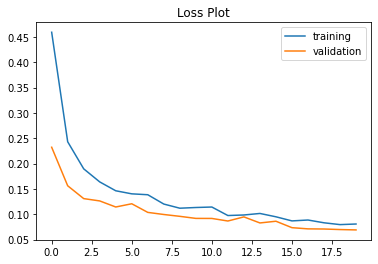

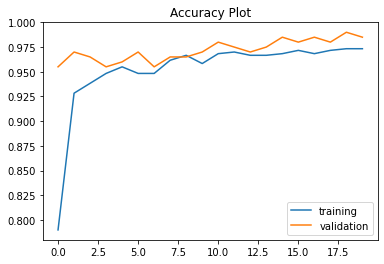

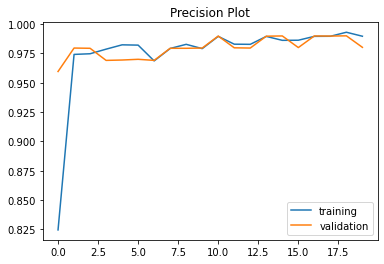

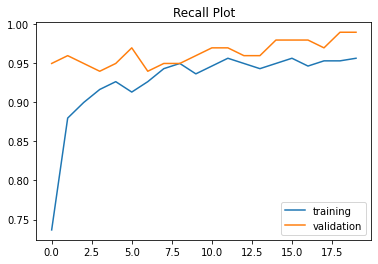

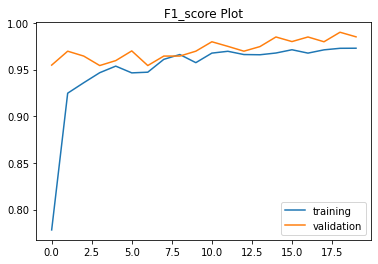

In [10]:
def plot_curves(history):
    metrics = [metric for metric in history.history if not metric.startswith('val')]
    val_metrics = {metric for metric in history.history if metric.startswith('val')}
    for metric in metrics:
        plt.figure()
        plt.plot(history.epoch, history.history[metric], label="training")
        val_metric = 'val_' + metric
        if val_metric in val_metrics:
            plt.plot(history.epoch, history.history[val_metric], label="validation")
        plt.title(f"{metric.capitalize()} Plot")
        plt.legend(loc="best")

plot_curves(history)

In [11]:
# Final Test on Test set
results = model.evaluate(test_ds, verbose=2)

7/7 - 8s - loss: 0.1642 - accuracy: 0.9900 - precision: 0.9804 - recall: 1.0000 - f1_score: 0.9901 - 8s/epoch - 1s/step


In [12]:
model.save_weights(model_name+".h5")